# Proceso de FE sobre dataset de entrenamiento

## Grupo 2

## Características analíticas

### Explicación del Código

1. **Cargar Datos**: Se cargan los datos desde los archivos CSV proporcionados.
2. **Unir Datos de Etiquetas**: Se unen los datos principales con los archivos de etiquetas para agregar nombres descriptivos a las IDs de razas, colores y estados.
3. **Crear Columnas Nuevas**: Se crean varias columnas nuevas para mejorar el análisis:
   - `IsPureBreed`: Indica si la mascota es de raza pura.
   - `AgeInYears`: Edad de la mascota en años.
   - `Healthy`: Indica si la mascota está en buenas condiciones de salud.
   - `IsFree`: Indica si la adopción es gratuita.
   - `Breed1_Rarity`: Rareza de la raza primaria.
   - `StatePopulation`: Población aproximada del estado.
   - `IsPeninsular`: Indica si el estado es peninsular.
   - `QuantityCategory`: Categoría de la cantidad de animales en la publicación.
   - `QuantityLog`: Transformación logarítmica de la cantidad de animales.
4. **Guardar Dataset**: Se guarda el dataset con las nuevas características de ingeniería en un nuevo archivo CSV.


In [2]:
%cd /app

/app


/usr/local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import pandas as pd
import numpy as np

# Paths - Definimos las rutas a los archivos necesarios
BASE_DIR = './'
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")
PATH_TO_BREED_LABELS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/breed_labels.csv")
PATH_TO_COLOR_LABELS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/color_labels.csv")
PATH_TO_STATE_LABELS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/state_labels.csv")
PATH_TO_SAVE_FE = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe.csv")

# Cargar los datos desde los archivos CSV
train_data_ext = pd.read_csv(PATH_TO_TRAIN)
breed_labels = pd.read_csv(PATH_TO_BREED_LABELS)
color_labels = pd.read_csv(PATH_TO_COLOR_LABELS)
state_labels = pd.read_csv(PATH_TO_STATE_LABELS)

# Unir datos de razas, colores y estados
# Estas uniones nos permiten agregar nombres descriptivos a las IDs de razas, colores y estados
train_data_ext = train_data_ext.merge(breed_labels, left_on=['Breed1', 'Type'], right_on=['BreedID', 'Type'], how='left', suffixes=('', '_PrimaryBreed'))
train_data_ext = train_data_ext.merge(breed_labels, left_on=['Breed2', 'Type'], right_on=['BreedID', 'Type'], how='left', suffixes=('', '_SecondaryBreed'))
train_data_ext = train_data_ext.merge(color_labels, left_on='Color1', right_on='ColorID', how='left', suffixes=('', '_Color1'))
train_data_ext = train_data_ext.merge(color_labels, left_on='Color2', right_on='ColorID', how='left', suffixes=('', '_Color2'))
train_data_ext = train_data_ext.merge(color_labels, left_on='Color3', right_on='ColorID', how='left', suffixes=('', '_Color3'))
train_data_ext = train_data_ext.merge(state_labels, left_on='State', right_on='StateID', how='left')

# Crear columna IsPureBreed considerando Breed1 y Breed2
# Esta columna indica si la mascota es de raza pura (1) o mixta (0)
# Excluimos las razas específicas que indican razas mixtas (307 para perros y 299 para gatos)
train_data_ext['IsPureBreed'] = (
    ((train_data_ext['Breed2'] == 0) & 
    ~((train_data_ext['Breed1'] == 307) & (train_data_ext['Type'] == 1)) & 
    ~((train_data_ext['Breed1'] == 299) & (train_data_ext['Type'] == 2)))
).astype(int)

# Crear columna AgeInYears
# Convertimos la edad de meses a años para facilitar la interpretación y análisis
train_data_ext['AgeInYears'] = train_data_ext['Age'] / 12

# Crear columna Healthy
# Indicamos si la mascota está en buenas condiciones de salud, considerando que esté vacunada, desparasitada y esterilizada
train_data_ext['Healthy'] = (
    (train_data_ext['Health'] == 1) & 
    (train_data_ext['Vaccinated'] == 1) & 
    (train_data_ext['Dewormed'] == 1) & 
    (train_data_ext['Sterilized'] == 1)
).astype(int)

# Crear columna IsFree
# Indicamos si la adopción de la mascota es gratuita (1) o no (0)
train_data_ext['IsFree'] = (train_data_ext['Fee'] == 0).astype(int)

# Calcular la rareza de las razas puras
# Contamos la cantidad de mascotas de cada raza para identificar razas raras o comunes
breed_counts = train_data_ext[train_data_ext['Breed2'] == 0]['Breed1'].value_counts()
train_data_ext['Breed1_Rarity'] = train_data_ext['Breed1'].map(breed_counts)

# Diccionario de poblaciones aproximadas por estado
# Estos valores nos permiten incorporar el tamaño de la población de cada estado en el análisis
state_population = {
    41324: 0.93, 41325: 2.07, 41326: 6.5, 41327: 1.77, 41330: 2.51, 
    41332: 1.1, 41335: 1.66, 41336: 3.78, 41342: 2.81, 41345: 3.9, 
    41361: 1.23, 41367: 1.84, 41401: 1.8, 41415: 0.1
}

# Incorporar población del estado
train_data_ext['StatePopulation'] = train_data_ext['State'].map(state_population)

# Indicador de zona peninsular o oriental
# Identificamos si el estado es peninsular (1) o no (0) para considerar diferencias geográficas
peninsular_states = {41324, 41325, 41326, 41327, 41330, 41332, 41335, 41336, 41361, 41367, 41401}
train_data_ext['IsPeninsular'] = train_data_ext['State'].apply(lambda x: 1 if x in peninsular_states else 0)

# Crear columna QuantityCategory
# Clasificamos la cantidad de animales en categorías ('1', '2-5', '6+') para capturar efectos no lineales
bins = [0, 1, 5, np.inf]
labels = ['1', '2-5', '6+']
train_data_ext['QuantityCategory'] = pd.cut(train_data_ext['Quantity'], bins=bins, labels=labels, include_lowest=True)

# Crear columna QuantityLog
# Aplicamos una transformación logarítmica a la cantidad de animales para manejar la escala
train_data_ext['QuantityLog'] = np.log1p(train_data_ext['Quantity'])

# Guardar el dataset con FE en la misma ruta de train.csv con el nombre train_fe.csv
train_data_ext.to_csv(PATH_TO_SAVE_FE, index=False)

# Verificar que se haya guardado correctamente
print(f"Dataset con FE guardado en: {PATH_TO_SAVE_FE}")


Dataset con FE guardado en: ./input/petfinder-adoption-prediction/train/train_fe.csv


In [4]:
# Cargar el dataset con FE guardado
train_data_ext_fe = pd.read_csv(PATH_TO_SAVE_FE)

# Mostrar las primeras filas del dataset guardado
print(train_data_ext_fe.head())


   Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...     StateName  IsPureBreed  AgeInYears  Healthy  IsFree  \
0             1  ...      Selangor            0    0.250000        0       0   
1             2  ...  Kuala Lumpur            1    0.083333        0       1   
2             2  ...      Selangor            0    0.083333        0       1   
3             2  ...  Kuala Lumpur            0    0.333333        0       0   
4             2  ...      Selangor            0    0.083333        0       1   

   Breed1_Rarity  StatePopulation  IsPeninsular Quantity

## Incorporamos el análisis de sentimientos que se realizó mediante apis
https://cloud.google.com/natural-language/docs/basics

### Explicación del Código

1. **Definir Rutas**: Se definen las rutas a los archivos necesarios, incluyendo la ruta al dataset con Feature Engineering previo y la carpeta con los archivos JSON de sentimiento.
2. **Cargar Dataset**: Se carga el dataset `train_fe.csv` que contiene las características creadas en la etapa anterior.
3. **Funciones para Cargar y Extraer Información de Sentimiento**:
   - `load_sentiment_data`: Carga los datos de sentimiento desde el archivo JSON correspondiente a un `PetID`.
   - `extract_sentiment_info`: Extrae `magnitude`, `score` y `language` de los datos de sentimiento.
   - `interpret_sentiment_score`: Interpreta el `score` de sentimiento para categorizarlo en "positive", "negative", "neutral" o "mixed".
4. **Crear Columnas para Datos de Sentimiento**: Se crean columnas vacías en el dataset para almacenar `SentimentMagnitude`, `SentimentScore`, `SentimentLanguage` y `SentimentInterpretation`.
5. **Iterar sobre los Registros**: Se itera sobre cada registro del dataset, cargando y extrayendo la información de sentimiento, y agregándola al dataset.
6. **Guardar el Dataset Actualizado**: Se guarda el dataset actualizado con la información de sentimiento en un nuevo archivo CSV `train_fe_sentiment.csv`.

In [5]:
import os
import pandas as pd
import numpy as np
import json

# Paths - Definimos las rutas a los archivos necesarios
BASE_DIR = './'
PATH_TO_TRAIN_FE = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe.csv")
PATH_TO_SENTIMENTS = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train_sentiment/")

# Cargar el dataset con Feature Engineering previo
train_data_fe = pd.read_csv(PATH_TO_TRAIN_FE)

# Función para cargar datos de sentimiento desde un archivo JSON
def load_sentiment_data(pet_id):
    sentiment_file = os.path.join(PATH_TO_SENTIMENTS, f'{pet_id}.json')
    if os.path.exists(sentiment_file):
        with open(sentiment_file) as f:
            sentiment_data = json.load(f)
            return sentiment_data
    else:
        return None

# Función para extraer la información relevante del análisis de sentimiento
def extract_sentiment_info(sentiment_data):
    if sentiment_data:
        document_sentiment = sentiment_data.get('documentSentiment', {})
        magnitude = document_sentiment.get('magnitude', None)
        score = document_sentiment.get('score', None)
        language = sentiment_data.get('language', None)
        return magnitude, score, language
    else:
        return None, None, None

# Función para interpretar el score de sentimiento
def interpret_sentiment_score(score):
    if score is None:
        return "unknown"
    elif score > 0.25:
        return "positive"
    elif score < -0.25:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "mixed"

# Crear columnas vacías para los datos de sentimiento
train_data_fe['SentimentMagnitude'] = np.nan
train_data_fe['SentimentScore'] = np.nan
train_data_fe['SentimentLanguage'] = ""
train_data_fe['SentimentInterpretation'] = ""

# Iterar sobre cada registro para extraer y agregar la información de sentimiento
for idx, row in train_data_fe.iterrows():
    pet_id = row['PetID']
    sentiment_data = load_sentiment_data(pet_id)
    magnitude, score, language = extract_sentiment_info(sentiment_data)
    
    train_data_fe.at[idx, 'SentimentMagnitude'] = magnitude
    train_data_fe.at[idx, 'SentimentScore'] = score
    train_data_fe.at[idx, 'SentimentLanguage'] = language
    train_data_fe.at[idx, 'SentimentInterpretation'] = interpret_sentiment_score(score)

# Guardar el dataset actualizado con la información de sentimiento
PATH_TO_SAVE_FE_SENTIMENT = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe_sentiment.csv")
train_data_fe.to_csv(PATH_TO_SAVE_FE_SENTIMENT, index=False)

# Verificar que se haya guardado correctamente
print(f"Dataset con FE y análisis de sentimiento guardado en: {PATH_TO_SAVE_FE_SENTIMENT}")


Dataset con FE y análisis de sentimiento guardado en: ./input/petfinder-adoption-prediction/train/train_fe_sentiment.csv


## Incorporar características de lemmas que tienen correlación relevante con las predicciones

## Explicación del código

1. **Limpieza y lematización del texto de las descripciones.**
2. **Aplicar TF-IDF a las descripciones lematizadas.**
3. **Calcular las correlaciones entre las palabras TF-IDF y la velocidad de adopción (`AdoptionSpeed`).**
4. **Crear nuevas características binarias basadas en la presencia de las palabras más correlacionadas.**
5. **Filtrar y guardar el DataFrame con las características seleccionadas, incluyendo la columna `Description`.**
6. **Visualizar la presencia de palabras correlacionadas con `AdoptionSpeed`.**


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Palabras más positivamente correlacionadas con AdoptionSpeed:
dog         0.081058
friendly    0.061207
spayed      0.045339
good        0.042111
loving      0.040112
forever     0.034631
need        0.029480
home        0.026706
year        0.026562
life        0.025645
dtype: float64

Palabras más negativamente correlacionadas con AdoptionSpeed:
kitten     -0.077073
email      -0.048213
adoption   -0.043392
litter     -0.041280
sibling    -0.038514
long       -0.035492
new        -0.035249
adopted    -0.035167
week       -0.034585
thank      -0.034346
dtype: float64
Dataset con FE, análisis de sentimiento y características de texto guardado en: ./input/petfinder-adoption-prediction/train/train_fe_text.csv


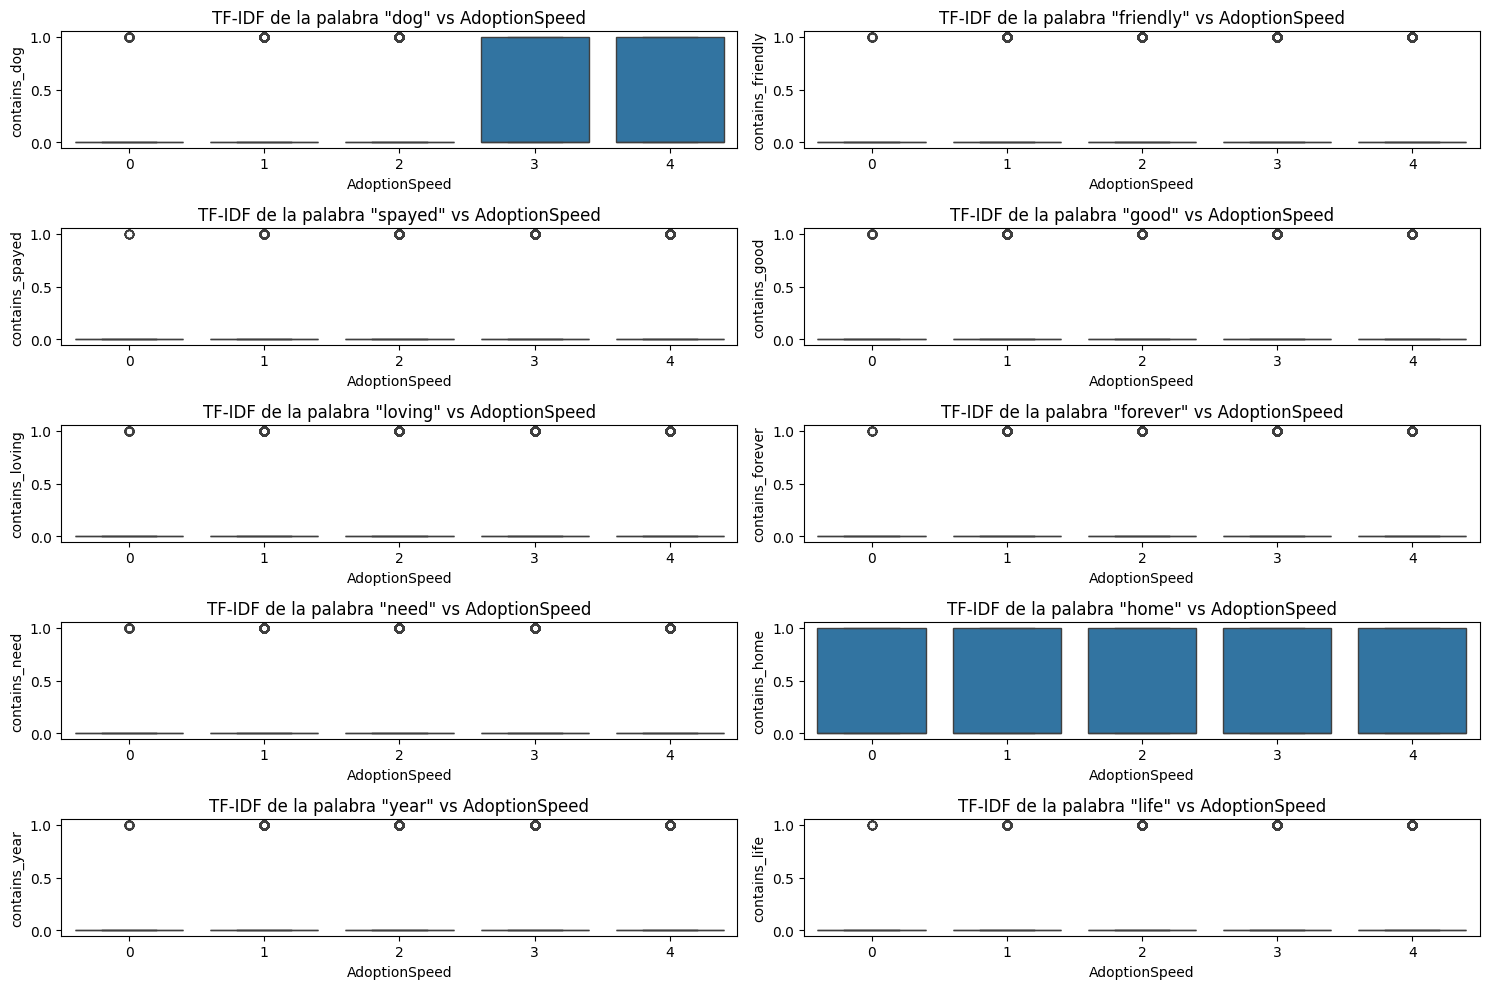

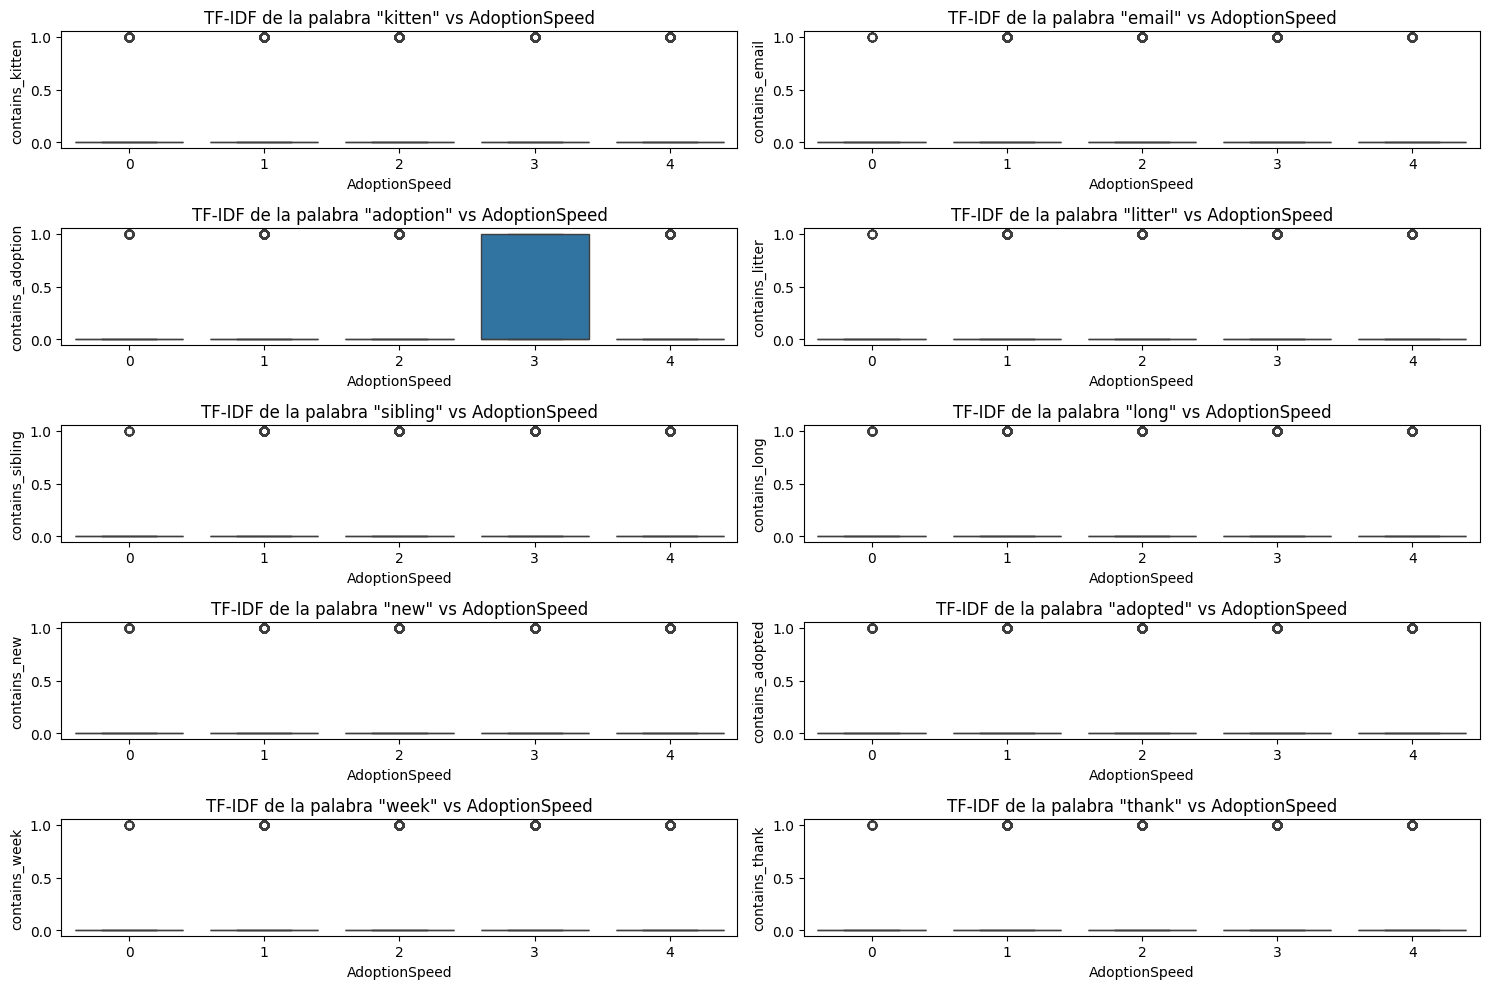

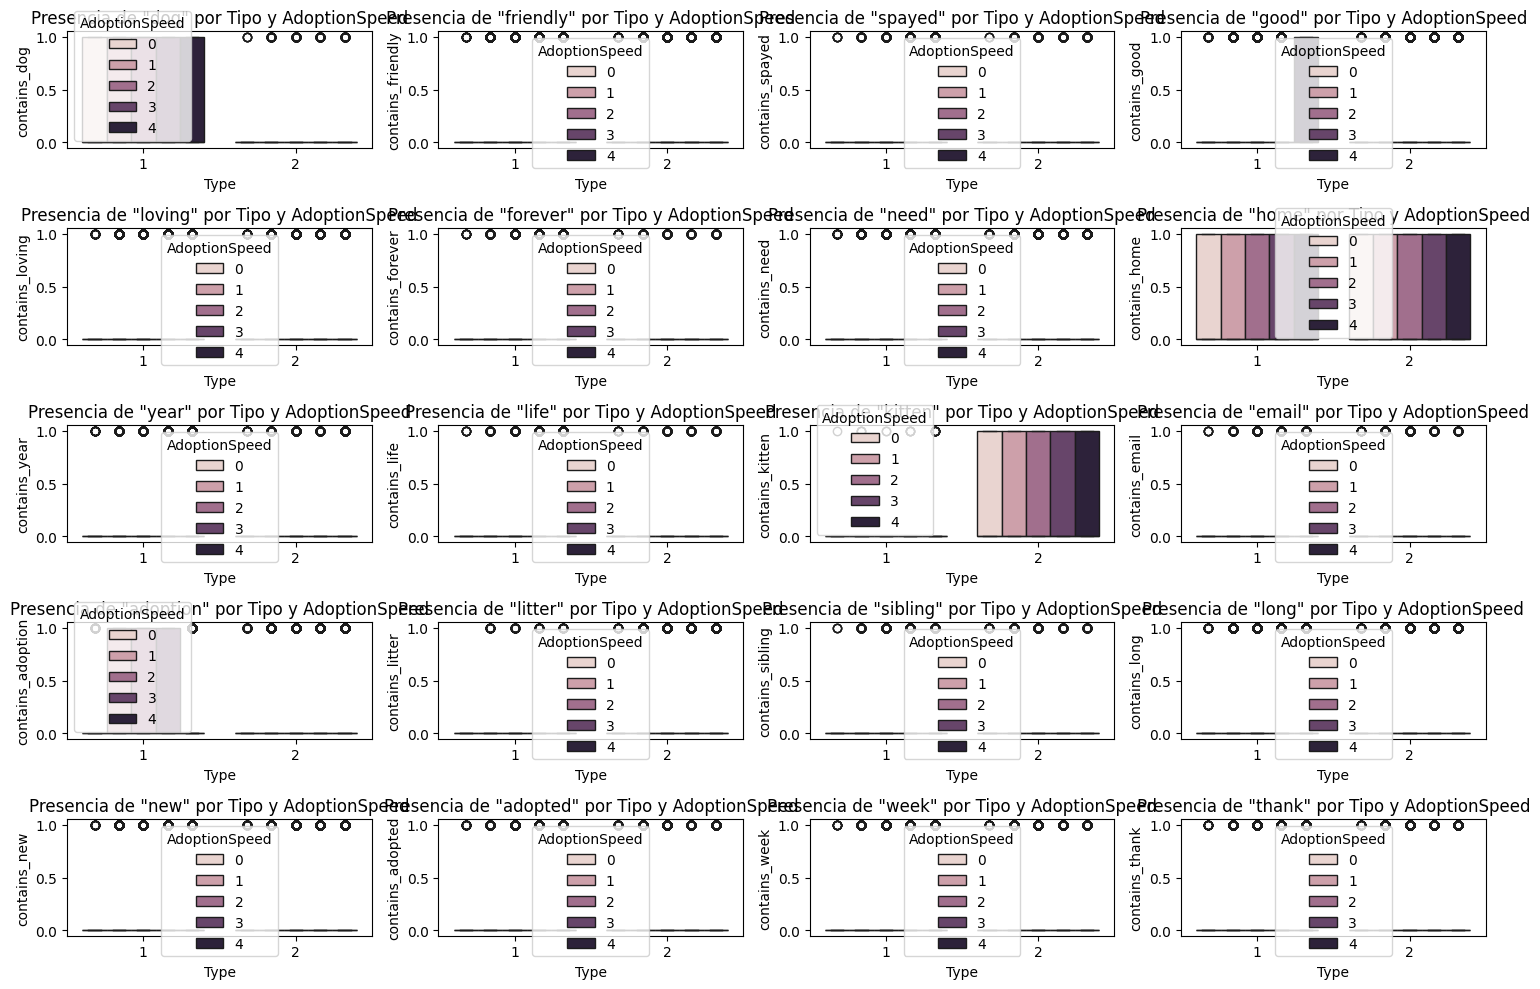

In [13]:
import os
import pandas as pd
import numpy as np
import json
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Paths - Definimos las rutas a los archivos necesarios
BASE_DIR = './'
PATH_TO_TRAIN_FE_SENTIMENT = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe_sentiment.csv")
PATH_TO_SAVE_FE_TEXT = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe_text.csv")

# Cargar el dataset con Feature Engineering y análisis de sentimiento previo
train_data_fe_sentiment = pd.read_csv(PATH_TO_TRAIN_FE_SENTIMENT)

# --- Limpieza y Lematización de Descripción ---

# Descargar los recursos necesarios para la lematización (solo la primera vez)
nltk.download('punkt')
nltk.download('wordnet')

# Instanciar el lematizador
lemmatizer = WordNetLemmatizer()

# Función para lematizar el texto
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmas)

# Reemplazar valores nulos en la columna 'Description' con una cadena vacía
train_data_fe_sentiment['Description'] = train_data_fe_sentiment['Description'].fillna('')

# Limpiar texto de la descripción (ejemplo básico)
train_data_fe_sentiment['Cleaned_Description'] = train_data_fe_sentiment['Description'].str.replace(r'[^\w\s]', '', regex=True).str.lower()

# Aplicar la lematización a la columna 'Cleaned_Description'
train_data_fe_sentiment['Lemmatized_Description'] = train_data_fe_sentiment['Cleaned_Description'].apply(lemmatize_text)

# Aplicar TF-IDF a la columna 'Lemmatized_Description'
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data_fe_sentiment['Lemmatized_Description'])

# Convertir a DataFrame y agregar al DataFrame original
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
train_data_fe_tfidf = pd.concat([train_data_fe_sentiment.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Calcular correlaciones
correlations = train_data_fe_tfidf[tfidf_vectorizer.get_feature_names_out()].corrwith(train_data_fe_tfidf['AdoptionSpeed'])

# Mostrar las palabras más correlacionadas positiva y negativamente
top_positive_correlations = correlations.sort_values(ascending=False).head(10)
top_negative_correlations = correlations.sort_values(ascending=True).head(10)

print("Palabras más positivamente correlacionadas con AdoptionSpeed:")
print(top_positive_correlations)

print("\nPalabras más negativamente correlacionadas con AdoptionSpeed:")
print(top_negative_correlations)

# Crear nuevas características para cada palabra correlacionada
important_words = list(top_positive_correlations.index) + list(top_negative_correlations.index)
for word in important_words:
    train_data_fe_tfidf[f'contains_{word}'] = train_data_fe_tfidf['Lemmatized_Description'].apply(lambda x: 1 if word in x else 0)

# Seleccionar solo las columnas necesarias para el modelo de LightGBM
columns_to_keep = [
    'Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
    'Quantity', 'Fee', 'State', 'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed',
    'IsPureBreed', 'AgeInYears', 'Healthy', 'IsFree', 'Breed1_Rarity', 'StatePopulation', 'IsPeninsular',
    'SentimentScore', 'SentimentMagnitude', 'SentimentLanguage'
] + [f'contains_{word}' for word in important_words]

# Filtrar el DataFrame para mantener solo las columnas seleccionadas
train_data_fe_cleaned = train_data_fe_tfidf.loc[:, columns_to_keep]

# Guardar el dataset limpio con las características seleccionadas
train_data_fe_cleaned.to_csv(PATH_TO_SAVE_FE_TEXT, index=False)

# Verificar que se haya guardado correctamente
print(f"Dataset con FE, análisis de sentimiento y características de texto guardado en: {PATH_TO_SAVE_FE_TEXT}")

# --- Visualización de la Presencia de Palabras ---

import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de las palabras más positivamente correlacionadas
plt.figure(figsize=(15, 10))
for i, word in enumerate(top_positive_correlations.index, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(data=train_data_fe_cleaned, x='AdoptionSpeed', y=f'contains_{word}')
    plt.title(f'TF-IDF de la palabra "{word}" vs AdoptionSpeed')
plt.tight_layout()
plt.show()

# Visualización de las palabras más negativamente correlacionadas
plt.figure(figsize=(15, 10))
for i, word in enumerate(top_negative_correlations.index, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(data=train_data_fe_cleaned, x='AdoptionSpeed', y=f'contains_{word}')
    plt.title(f'TF-IDF de la palabra "{word}" vs AdoptionSpeed')
plt.tight_layout()
plt.show()

# Visualizar la presencia de palabras por tipo de mascota y AdoptionSpeed
plt.figure(figsize=(15, 10))
for i, word in enumerate(important_words, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(data=train_data_fe_cleaned, x='Type', y=f'contains_{word}', hue='AdoptionSpeed')
    plt.title(f'Presencia de "{word}" por Tipo y AdoptionSpeed')
plt.tight_layout()
plt.show()
